# Distgen basic usage
--------------------

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import numpy as np
import os
import yaml

Distgen supports nearly arbitrary generation of 6D + time particle coordinates.  

# Generator

Generator class defines the main object that creates a beam distribution.  Typical usage is to supply the `Generator.__init__(input, verbose)` with an input file name and a verbose integer value to control the level of output printed to the user.  Input file types can be either json or YAML. The user may also supply a dictionary as the input argument.

In [2]:
from distgen import Generator

In [3]:
gen = Generator('data/rad.gaussian.in.yaml', verbose=0) 

Printing a Generator object displays the basic input data read from a distgen input file:

In [4]:
print(gen)

<disgten.Generator with input: 
n_particle: 200000
output:
  file: rad.gaussian.out.txt
  type: gpt
r_dist:
  sigma_xy:
    units: millimeter
    value: 2
  type: radial_gaussian
random:
  type: hammersley
species: electron
start:
  MTE:
    units: millielectron_volt
    value: 150
  type: cathode
t_dist:
  max_t:
    units: picosecond
    value: 2
  min_t:
    units: picosecond
    value: -2
  type: uniform
total_charge:
  units: picocoulomb
  value: 10
transforms: null

>


This data is stored internally in fully parsed form.  To get this structure it, use the convenience property `Generator.input`.  Note: there is no setter.

In [5]:
gen.input

{'n_particle': 200000,
 'output': {'file': 'rad.gaussian.out.txt', 'type': 'gpt'},
 'r_dist': {'sigma_xy': {'value': 2, 'units': 'millimeter'},
  'type': 'radial_gaussian'},
 'random': {'type': 'hammersley'},
 'species': 'electron',
 'start': {'MTE': {'value': 150, 'units': 'millielectron_volt'},
  'type': 'cathode'},
 't_dist': {'max_t': {'value': 2, 'units': 'picosecond'},
  'min_t': {'value': -2, 'units': 'picosecond'},
  'type': 'uniform'},
 'total_charge': {'value': 10, 'units': 'picocoulomb'},
 'transforms': None}

The input structure allows for four top levels: generator, beam, {variable}_dists, transforms, and output.  Any other input will throw an exception when attempting to create the beam:

In [6]:
try:
    gen['foo']='bar'
except Exception as ex:
    print(ex)

Unexpected distgen input parameter: foo


Distgen generator.input is a nested dictionary by design.  While this logically organizes the input, it can be somewhat cumbersome for changing input.  Thus the generator.input dictionary can be accessed with pure strings via the [...] method with a flattened dictionary (nested keys separated by ':'):

In [7]:
gen['start']

{'MTE': {'value': 150, 'units': 'millielectron_volt'}, 'type': 'cathode'}

In [8]:
gen['start:MTE']

{'value': 150, 'units': 'millielectron_volt'}

Brackets can also be used to set parameters.  When setting a parameter that has associated units, one must either specify whether setting the value or units, or pass in only the value:

In [9]:
gen['start:MTE:value']=120
print('New MTE setting:', gen['start:MTE'])

New MTE setting: {'value': 120, 'units': 'millielectron_volt'}


In [10]:
gen['start:MTE:units']='eV'
print('New MTE setting:', gen['start:MTE'])

New MTE setting: {'value': 120, 'units': 'electron_volt'}


In [11]:
gen['start:MTE']=100
print('New MTE setting:', gen['start:MTE'])

New MTE setting: {'value': 100, 'units': 'electron_volt'}


To create a distribution, run `Generator.beam()`:

In [12]:
gen = Generator('data/rad.gaussian.in.yaml', verbose=1) 
beam = gen.beam()

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.


   Assuming cylindrical symmetry...


   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 276.857 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.0212516 eV/c -> 0 eV/c
   Scaling sigma_px = 276.849 eV/c -> 276.857 eV/c
   Shifting avg_py = -0.0259627 eV/c -> 0 eV/c
   Scaling sigma_py = 276.844 eV/c -> 276.857 eV/c
   Shifting avg_pz = -0.0372953 eV/c -> 0 eV/c
   Scaling sigma_pz = 276.843 eV/c -> 276.857 eV/c
   Shifting avg_t = -4.90022E-05 ps -> 0 ps
   Scaling sigma_t = 1.1547 ps -> 1.1547 ps
   Cathode start: fixing pz momenta to f

Alternatively, call `.run()`, which creates an openPMD-beamphysics style ParticleGroup

In [13]:
gen.verbose=False
gen.run()
gen.particles

<ParticleGroup with 200000 particles at 0x7f209022b550>

Internally, Distgen uses the Pint module to handle/check units automatically, see [PINT](https://pint.readthedocs.io/en/stable/).

# Physical Constants

All physical constants used by Distgen are accessed via the main PHYSICAL_CONSTANTS object.  Access to specific constants is done via [...], and returns the associated quantity (value with units) from the SciPy physical_constants module.


In [14]:
from distgen import PHYSICAL_CONSTANTS

In [15]:
PHYSICAL_CONSTANTS['elementary charge']

1.602176634e-19 <Unit('coulomb')>

## Particle Species

As of v2.0.0, additional particle species can be generated.  The supported list is:

In [16]:
PHYSICAL_CONSTANTS.species_list

['electron', 'photon', 'positron', 'proton', 'muon', 'neutron', 'tau']

Species specific data can be accessed via the `.species` function, which returns a dictionary of species specific parameters:

In [17]:
PHYSICAL_CONSTANTS.species('electron')

{'charge': -1.602176634e-19 <Unit('coulomb')>,
 'mass': 9.1093837015e-31 <Unit('kilogram')>,
 'mc2': 510998.94999999995 <Unit('electron_volt')>,
 'g_factor': -2.00231930436256 <Unit('dimensionless')>}

# Beam Object

The particle coordinates created by the Generator class are stored internally a beam obect.  The main underlying coordinates are the 6D phase space coordinates $x$, $y$, $z$, $p_x$, $p_y$, $p_z$, and time $t$.  These can be accessed via the [...] operator.  The bunch charge is given by beam.q.

In [18]:
gen = Generator('data/rad.gaussian.in.yaml', verbose=0) 
beam = gen.beam()
print("X coordinates:", beam['x'])
print("Bunch charge:", beam['q'])

X coordinates: [1.289022452108133 3.050762686067514 2.1456876750642953 ... 2.6094886627111644 1.7667918315956421 3.722370619054455] millimeter
Bunch charge: 10 picocoulomb


Currently, the code assumes one particle species (default: electrons) per beam object.  The bunch contains an array of particle weights (currently uniform) for use with averaging.  The particle weights $w$ are normalized $\sum_i{w_i}=1$ and are used for computing expectation values over the particle ensemble. 

Simple examples include beam.avg: $\langle\mathcal{O}\rangle = \sum_i w_i\mathcal{O}_i$ and beam.std(): $\sigma_{\mathcal{O}} = \sqrt{\sum_i{w_i(\mathcal{O}_i-\langle\mathcal{O}\rangle)^2}}$.

Other examples include the normalized and geometric emittance and the twiss parameters $\beta$ and $\alpha$  (See the distgen.beam.py).



In [19]:
print("Beam species:",beam.species)
print("Weights:",beam["w"])
print("Normalization sum(weights): ",np.sum(beam["w"]))
print(f'Avgerage of X: {beam.avg("x"):G~P}')
print(f'Standard Deviation of X: {beam.std("x",desired_units="mm"):G~P}')

Beam species: electron
Weights: [5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06] dimensionless
Normalization sum(weights):  1.0 dimensionless
Avgerage of X: -3.46945E-17 mm
Standard Deviation of X: 2 mm


# Generating OpenPMD-beamphysics Particle Group objects
Distgen supports direct creation of OpenPMD beam physics particle group objects, a very useful object for handling beam distribitions and writing them to various codes.  Please see https://github.com/ChristopherMayes/openPMD-beamphysics for details.  To generate a OpenPMD-beamphysics particle group, use the `run()` command. The resulting ParticleGroup is saved as `Generator.particles`:

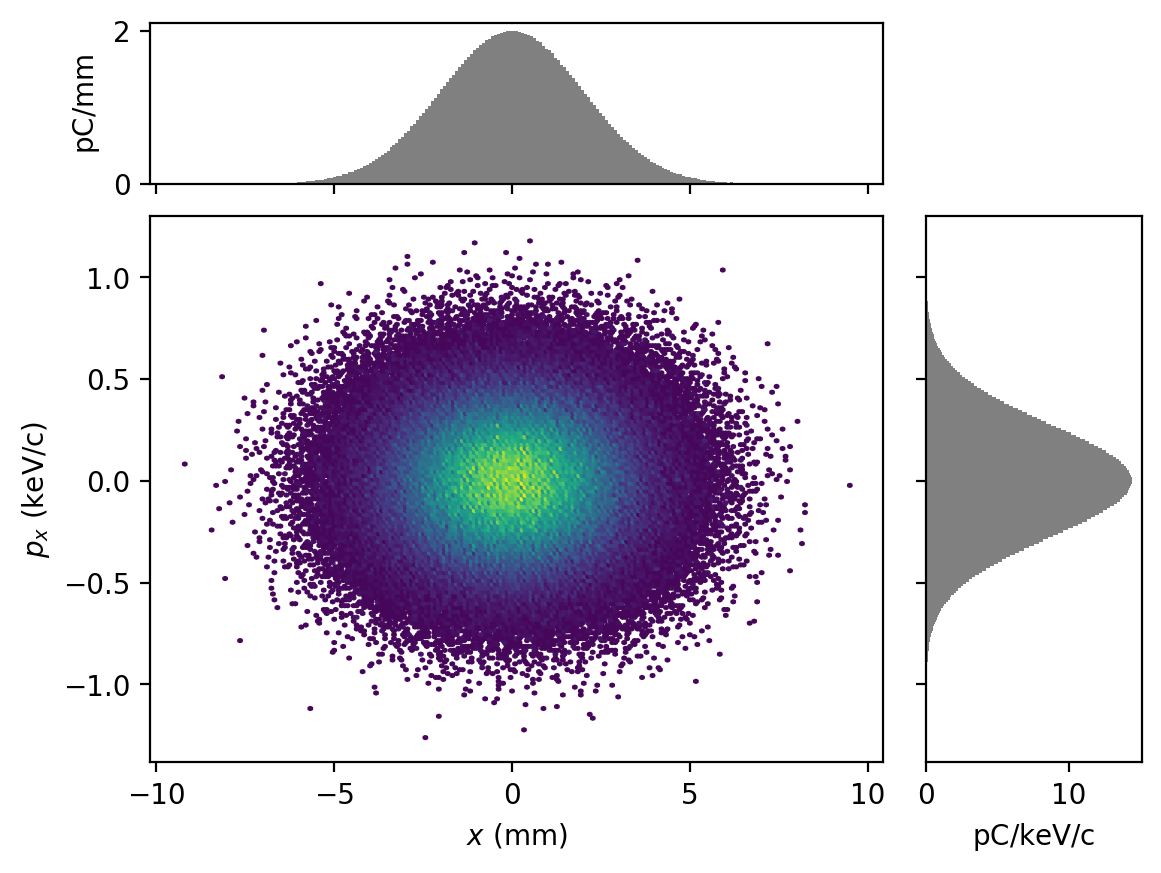

In [20]:
gen.run()
pg = gen.particles
pg.plot('x', 'px')

# Distribution Objects
Distgen handles distirbutions using classes controlled by Generator.  Currently there are three types supported: 1D distributions (Dist1d), radial distributions for the $r$ coordinate, and 2D distributions.  Each distribution type keeps an internal list of the required and optional parameters that must be passed to the object.  When a distribution object is initialized, the input parameters are checked against this list. Unexpected inputs will throw exceptions:

In [21]:
gen = Generator('data/rad.gaussian.in.yaml', verbose=0) 
try:
    gen['r_dist:foo']='bar' 
    gen.beam()
except Exception as ex:
    print(ex)

Incorrect param given to NormRad.__init__(**kwargs): foo
Allowed params: ['sigma_xy', 'truncation_fraction', 'truncation_radius_left', 'truncation_radius_right', 'n_sigma_cutoff_left', 'n_sigma_cutoff_left', 'n_sigma_cutoff', 'truncation_radius', 'truncation_radius_left', 'truncation_radius_right', 'verbose', 'type', 'indent']


As will missing required parameters:

In [22]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 
try:
    gen['r_dist']={}
    gen.beam()   
except Exception as ex:
    print(ex)

No distribution type for r specified.


# Output writer functionality 
Distgen supports writer functions for various output formats/codes.  Currently these include GPT and ASTRA, and the openPMD specification.  To write to a file, use distgen.writers.writer with appropriate code type specified as well as the beam object and desired output file.  The writer function accepts additional parameters required for any code dependent output.

In [23]:
from distgen.writers import writer

gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

# Typically the user can just call the general write function and specify the desired format:
writer("gpt", beam, "gpt.out.txt", verbose=1)
writer("astra", beam, "astra.out.txt", verbose=1)
writer("openPMD", beam, "openPMD.out.h5", verbose=1)

Printing 200000 particles to "gpt.out.txt": 

done. Time ellapsed: 1.27292 s.
Printing 200000 particles to "astra.out.txt": 

done. Time ellapsed: 1.4308 s.
Printing 200000 particles to "openPMD.out.h5": done. Time ellapsed: 17.9582 ms.


# Plotting 
Distgen provides the user with some basic plotting routines for help in visualizing the beam coordinates.  The most common plot types include `plot_dist2d`, `plot_dist1d`, `plot_radial_dist`, and `plot_current_profile`.  Below shows an example of how to plot 2 coordinates, in this case $x$ and $y$.  The coloring scheme is a scatter histogram.

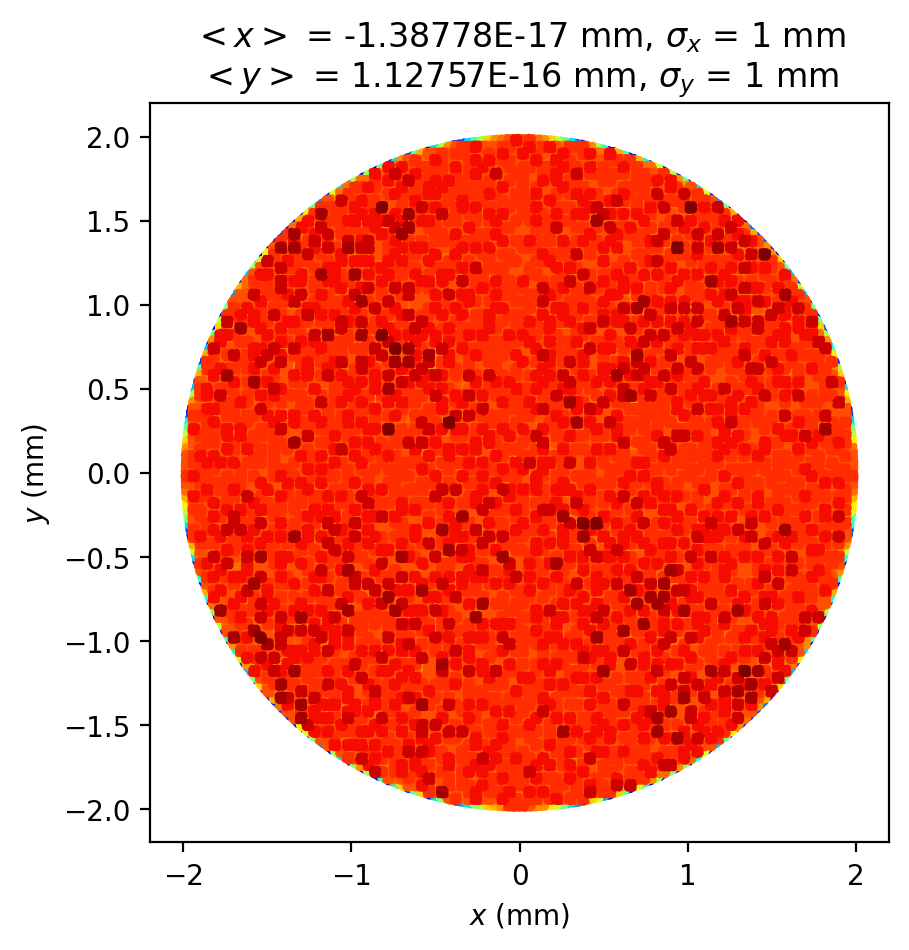

In [24]:
# The distgen module has some basic plotting routines
from distgen.plot import *

units = {'x':'mm','y':'mm','z':'mm', 'r':'mm', 
         'px':'keV/c','py':'keV/c','pz':'keV/c',
         't':'ps','q':'pC','thetax':'mrad','I':'A'}

gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

fig=plt.figure(1)
# X-Y Plot
plot_dist2d(beam, 
            'x', units['x'],
            'y', units['y'],
            style='scatter_hist2d',
            nbins=100,
            axis='equal',
            title_on=True);

For plotting the histogram of the radial coordinate $r$, use `plot_radial_dist`:

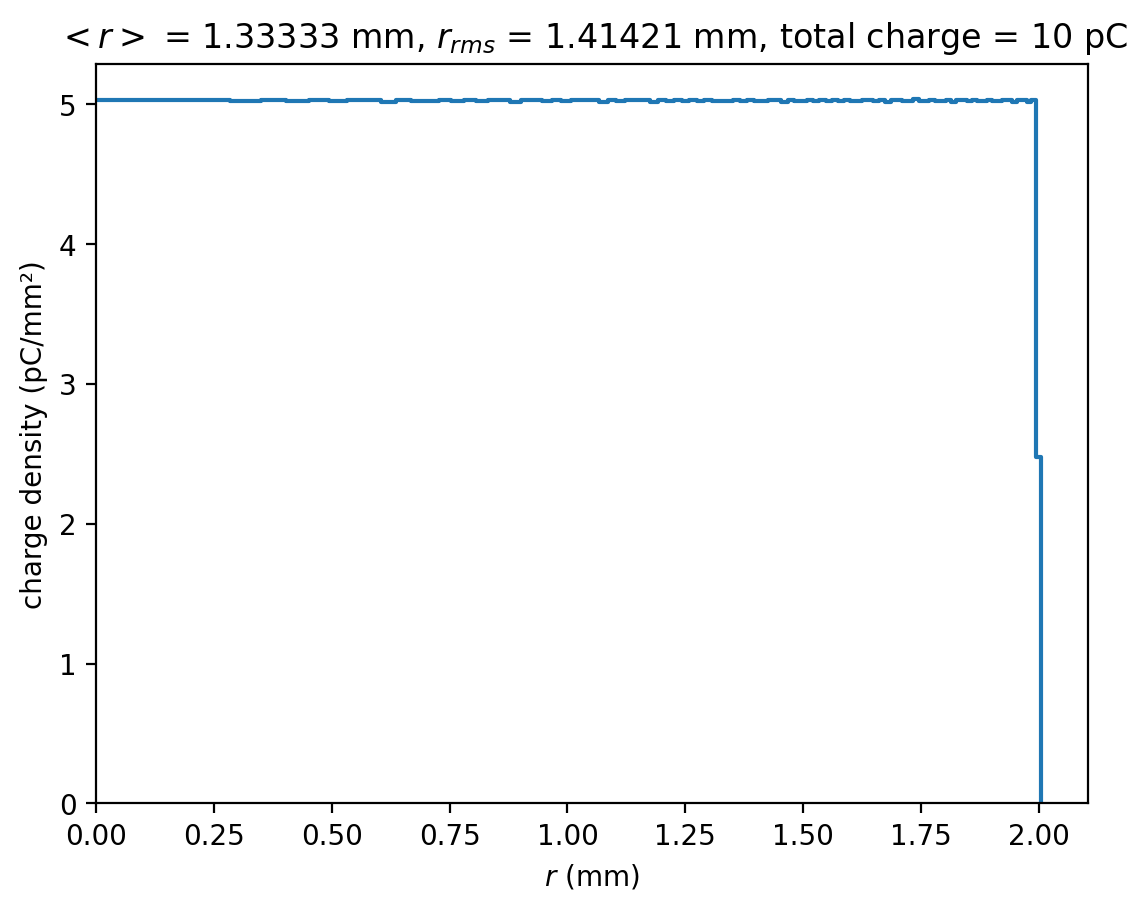

In [25]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

plot_radial_dist(beam, units['r'], scale='charge', nbins=100, title_on=True);

For plotting 1D projections of the beam distribution, use `plot_dist1d`:

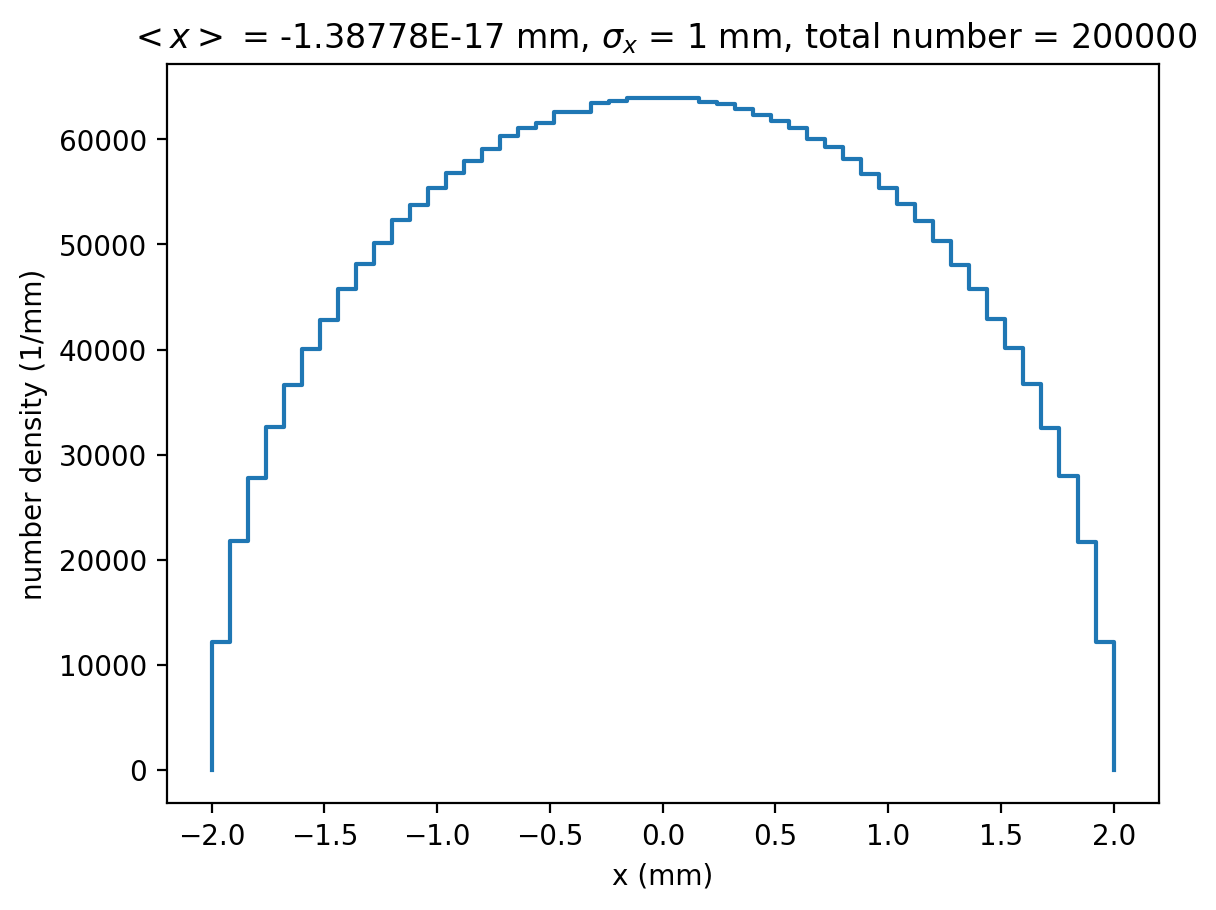

In [26]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

plot_dist1d(beam, 'x', units['x'], scale='number', nbins=50, title_on=True)

For plotting the current profile, use `plot_current_profile`:

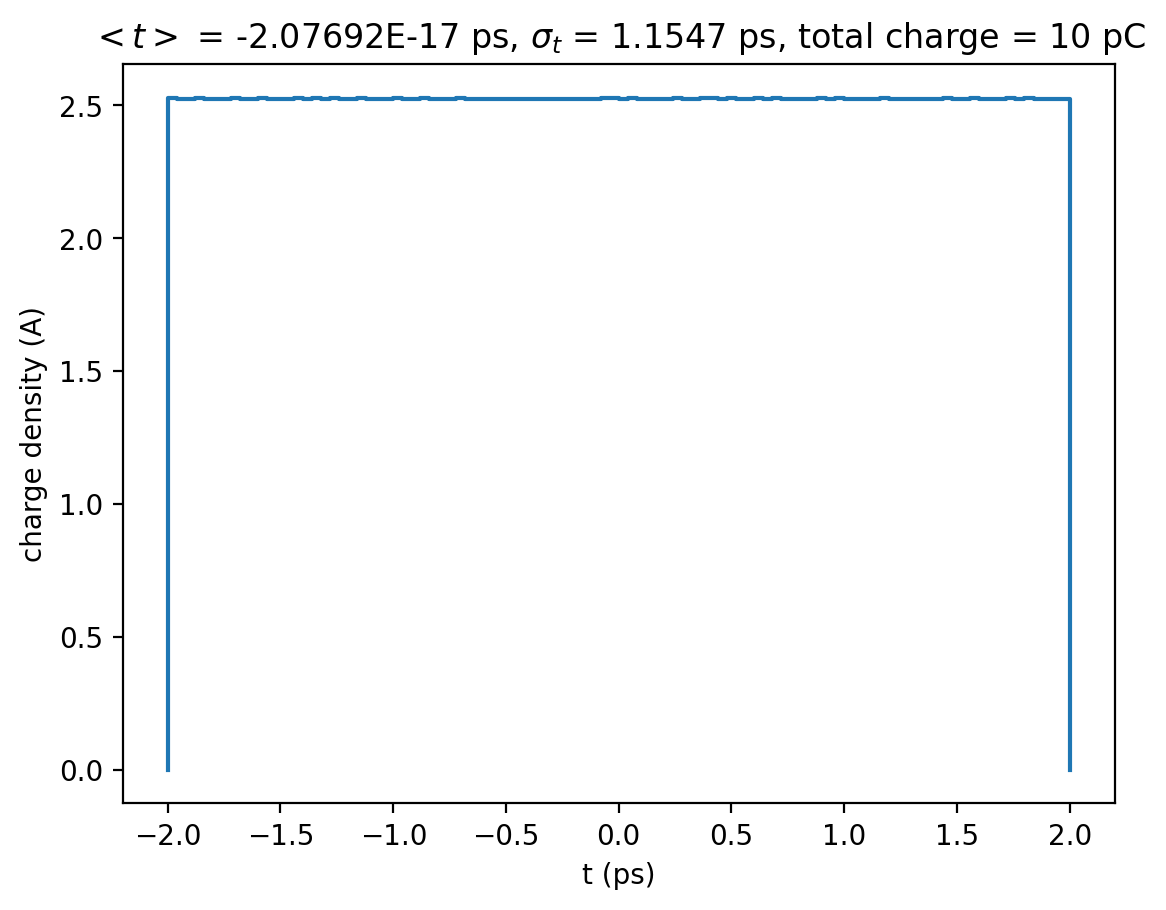

In [27]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

plot_current_profile(beam, units['t'], units['I'], title_on=True, nbins=100);

# Running Distgen with driver functions
The main in python driver function for distgen is `distgen.drivers.run_distgen()`.  The function creates its own Generator object and returns a beam object.  Inputs can either be an inputfile or a parsed distgen supported input dictionary.  Here the function is run with an input dictionary created above.

In [28]:
from distgen.drivers import run_distgen

with open('data/rad.gaussian.in.yaml') as fid:
    p = yaml.safe_load(fid)

p

{'n_particle': 200000,
 'output': {'file': 'rad.gaussian.out.txt', 'type': 'gpt'},
 'r_dist': {'sigma_xy': '2 mm', 'type': 'radial_gaussian'},
 'random': {'type': 'hammersley'},
 'species': 'electron',
 'start': {'MTE': '150 meV', 'type': 'cathode'},
 't_dist': {'max_t': '2 ps', 'min_t': '-2 ps', 'type': 'uniform'},
 'total_charge': '10 pC'}

In [29]:
beam = run_distgen(inputs=p, verbose=1)

Distribution format: gpt
Output file: /home/runner/work/distgen/distgen/docs/examples/rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.


   Assuming cylindrical symmetry...


   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 276.857 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.0212516 eV/c -> 0 eV/c
   Scaling sigma_px = 276.849 eV/c -> 276.857 eV/c
   Shifting avg_py = -0.0259627 eV/c -> 0 eV/c
   Scaling sigma_py = 276.844 eV/c -> 276.857 eV/c
   Shifting avg_pz = -0.0372953 eV/c -> 0 eV/c
   Scaling sigma_pz = 276.843 eV/c -> 276.857 eV/c
   Shifting avg_t = -4.90022E-05 ps -> 0 ps
   Scaling sigma_t = 1.1547 ps -> 1.1547 ps
   Cathode start: fixing pz momenta to f

Printing 200000 particles to "/home/runner/work/distgen/distgen/docs/examples/rad.gaussian.out.txt": 

done. Time ellapsed: 1.29829 s.

Beam stats:
   avg_x = 0 mm, sigma_x = 2 mm
   avg_y = 2.06253E-16 mm, sigma_y = 2 mm
   avg_z = 0 mm, sigma_z = 0 mm
   avg_px = -6.66134E-16 eV/c, sigma_px = 276.857 eV/c
   avg_py = -6.55986E-15 eV/c, sigma_py = 276.857 eV/c
   avg_pz = 220.904 eV/c, sigma_pz = 166.887 eV/c
   avg_t = -2.04087E-17 ps, sigma_t = 1.1547 ps


Below the function is called with 'inputs' pointing to an input file.  The function can also take  accept a flattened settings dict, which updates inputs:

In [30]:
new_settings = {'start:MTE:value':0.1}
beam = run_distgen(settings=new_settings, inputs=p, verbose=1)

Replacing parameter start:MTE:value with value 0.1.
Distribution format: gpt
Output file: /home/runner/work/distgen/distgen/docs/examples/rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.


   Assuming cylindrical symmetry...


   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 7.148 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 7.148 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 7.148 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.000548713 eV/c -> 0 eV/c
   Scaling sigma_px = 7.14822 eV/c -> 7.14842 eV/c
   Shifting avg_py = -0.000670353 eV/c -> 0 eV/c
   Scaling sigma_py = 7.14809 eV/c -> 7.14842 eV/c
   Shifting avg_pz = -0.000962959 eV/c -> 0 eV/c
   Scaling sigma_pz = 7.14807 eV/c -> 7.14842 eV/c
   Shifting avg_t = -4.90022E-05 ps -> 0 ps
   Scaling sigma_t = 1.1547 ps -> 1.1547 ps
   Cathode start: fixing pz momenta to f

Printing 200000 particles to "/home/runner/work/distgen/distgen/docs/examples/rad.gaussian.out.txt": 

done. Time ellapsed: 1.3194 s.

Beam stats:
   avg_x = 0 mm, sigma_x = 2 mm
   avg_y = 2.06253E-16 mm, sigma_y = 2 mm
   avg_z = 0 mm, sigma_z = 0 mm
   avg_px = -1.08149E-16 eV/c, sigma_px = 7.14842 eV/c
   avg_py = -8.1261E-17 eV/c, sigma_py = 7.14842 eV/c
   avg_pz = 5.70372 eV/c, sigma_pz = 4.309 eV/c
   avg_t = -2.04087E-17 ps, sigma_t = 1.1547 ps


Finally, is also possible to run distgen as an executible script using `/bin/DistGen.py`

In [31]:
import subprocess
output=subprocess.check_output(['Distgen','-f','data/rad.gaussian.in.yaml','-v','2'])
output=str(output.decode('utf-8')).split("\n")
for line in output:
    print(line)

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.
   Assuming cylindrical symmetry...
   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 276.857 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.0212516 eV/c -> 0 eV/c
   Scaling sigma_px = 276.849 eV/c -> 276.857 eV/c
   Shifting avg_py = -0.0259627 eV/c -> 0 eV/c
   Scaling sigma_py = 276.844 eV/c -> 276.857 eV/c
   Shif

# Scaling/Rotating/Shifting Coordinates

The distgen module allows the user with several options for applying coordinate transformations.  Some of the basic operations include: shifting, scaling, and rotating coordinates.  See the transform.ipynb for a detailed description of this functionality. 

# Cathode Distributions
---

Currently Distgen supports several cathode emission models.  Currently these all assume the particles are emitted on a flat surface at z = 0 m. The particle time coordinates in this case effectively respresents the emission time of the particle from the cathode, and thus the time distribution should be set by the user.  For photocathodes, the time coordinate can be related to the laser pulse longitudinal intensity. To designate emission from a cathode, please set the input key `start:type` = `cathode`

WARNING: the user is ultimately responsible to make sure the cathode model is physically consistent with the particle species generated.

## 1. Maxwell-Boltzmann (default): thermalized particle momenta

Particles emitted from this type of cathode are assumed to have a Maxwell-Boltzmann distribution for their total mometnum $|p|$ parameterized by an energy scale denoted $MTE$: 

$\rho_p(|p|) = \left(\frac{1}{2\pi mMTE}\right)^{3/2} 4\pi |p|^2 \exp\left(-\frac{|p|^2}{2m MTE}\right)$, with $\int\rho_p(|p|)d|p| = 1$.

Assuming spherical symmetry, it is easy to show the corresponding PDF for the components of the momenta is given by:

$\rho(p_x,p_y,p_z) = \left(\frac{1}{2\pi mMTE}\right)^{3/2}\exp\left(-\frac{p_x^2+p_y^2+p_z^2}{2m MTE}\right)$, with $\int\rho(p_x,p_y,p_z) d^3p=1$.

From the equipartition theorem the average energy $\frac{3}{2}MTE$ is divided equally among each direction and thus the energy scale $MTE$ can be identified as the Mean Transverse Energy: $MTE=\frac{\langle p_x^2\rangle}{2m} + \frac{\langle p_y^2\rangle}{2m}$.  

This expression can be used to relate the MTE to the initial cathode emittance:

$\epsilon_{n,x} = \sigma_{x}\sqrt{ \frac{MTE}{mc^2} }$

assuming there is no distinction between the $p_x$ and $p_y$ distributions inherent to the emission process.  To account for the fact that particles with $p_z<0$ are not emitted from the cathode, distgen takes $p_z = |p_z|$. Becauset this model serves as the default, simpy setting the input key `start:MTE` to a value (with units) will instruct the Generator to assume thermalized momenta. Note the absolute value of the $p_z$ components is taken.

In [32]:
from distgen import Generator
gen = Generator(input_file="data/rad.gaussian.in.yaml", verbose=1)

In [33]:
beam = gen.beam()

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.


   Assuming cylindrical symmetry...


   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 276.857 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.0212516 eV/c -> 0 eV/c
   Scaling sigma_px = 276.849 eV/c -> 276.857 eV/c
   Shifting avg_py = -0.0259627 eV/c -> 0 eV/c
   Scaling sigma_py = 276.844 eV/c -> 276.857 eV/c
   Shifting avg_pz = -0.0372953 eV/c -> 0 eV/c
   Scaling sigma_pz = 276.843 eV/c -> 276.857 eV/c
   Shifting avg_t = -4.90022E-05 ps -> 0 ps
   Scaling sigma_t = 1.1547 ps -> 1.1547 ps
   Cathode start: fixing pz momenta to f

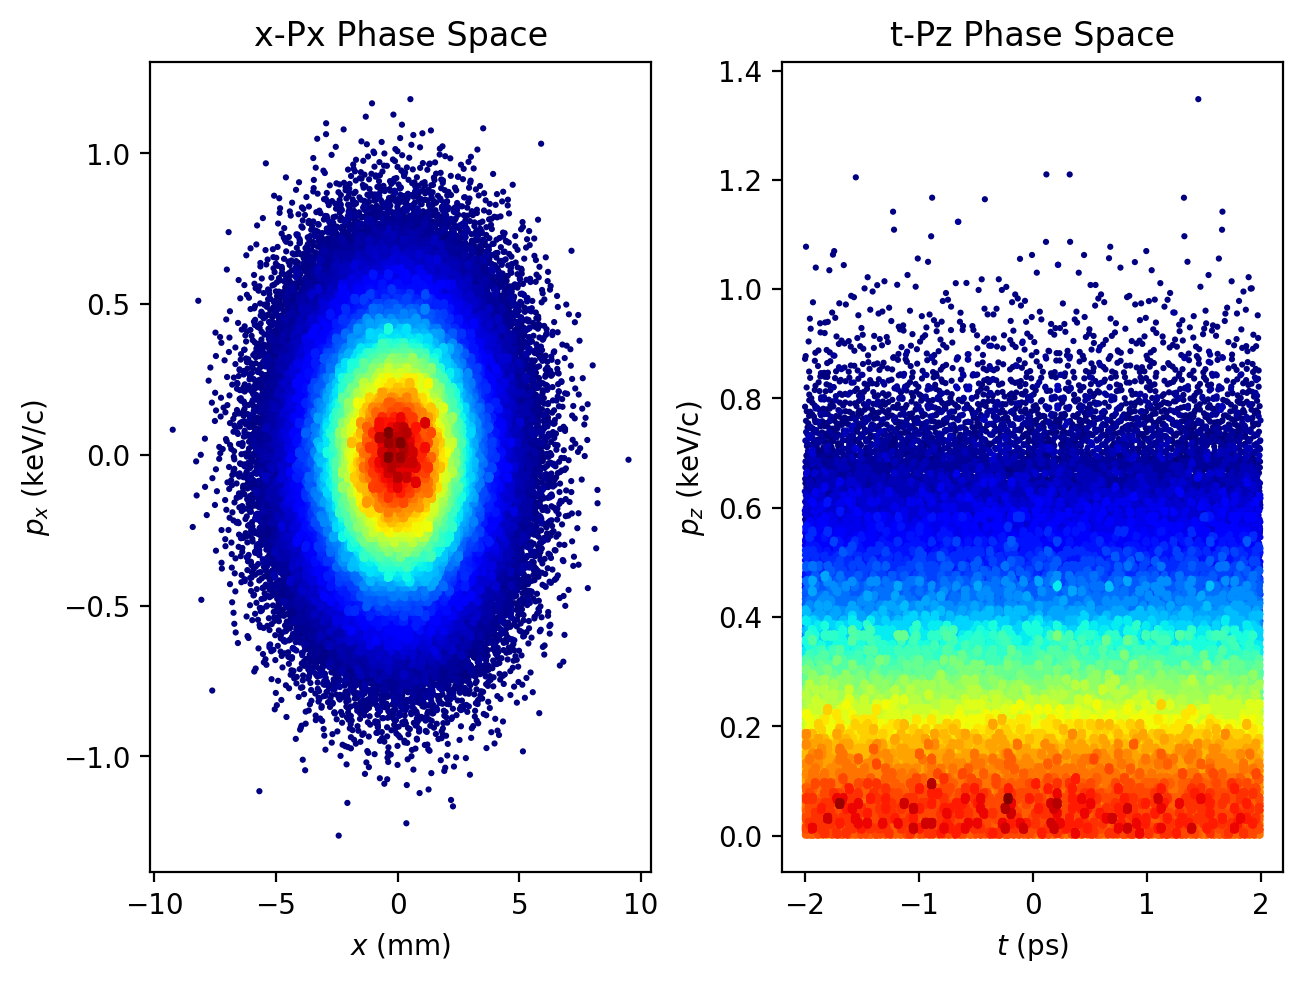

In [34]:
fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)

plot_dist2d(beam, 'x', units['x'], 'px', units['px'], ax=ax[0]);
ax[0].set_title('x-Px Phase Space')

plot_dist2d(beam, 't', units['t'], 'pz', units['pz'], ax=ax[1]);
ax[1].set_title('t-Pz Phase Space');

## Fermi-Dirac 3 Step Barrier Photocathode

Calculates the PDF for electrons emitted from a photocathode following the
model described in [1]. 

The input parameters for this are the photon (laser) wavelength, as well as the cathode temperature, work function, and Fermi energy.

Shortly, electrons are initially populated in momentum space as 
in the Sommerfeld model. They escape over the work function barrier when their 
longitudinal energy is high enough and lose momentum along the direction of the surface 
normal to satisfy energy conservation. This sampling concept is the same described in [2].

    [1] Dowell, D. H., & Schmerge, J. F. (2009). Quantum efficiency and thermal emittance of 
        metal photocathodes. Physical Review Special Topics - Accelerators and Beams, 12(7). 
        https://doi.org/10.1103/PhysRevSTAB.12.074201

    [2] Pierce, C. M., Durham, D. B., Riminucci, F., Dhuey, S., Bazarov, I., Maxson, J.,
        Minor, A. M., & Filippetto, D. (2023). Experimental Characterization of Photoemission
        from Plasmonic Nanogroove Arrays. Physical Review Applied, 19(3), 034034.
        https://doi.org/10.1103/PhysRevApplied.19.034034

In [35]:
gen = Generator('data/fermi_dirac_3step_barrier_photocathode.in.yaml', verbose=1)

beam = gen.beam()

Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.


   Assuming cylindrical symmetry...
   Assuming cylindrical momentum symmetry...


   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   |p| and polar angle distribution: Fermi-Dirac 3 Step Barrier Photocathode Model
      laser wavelength = 495.937 nm, photon energy = 2.5 eV
      cathode temperature = 300 K, cathode work function = 2 eV, Fermi energy = 6 eV


   azimuthal angle distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -17.3205 ps, max_t = 17.3205 ps
   Shifting avg_x = -9.22801E-06 mm -> 0 mm
   Scaling sigma_x = 0.99994 mm -> 1 mm
   Shifting avg_y = 9.98282E-06 mm -> 0 mm
   Scaling sigma_y = 0.999945 mm -> 1 mm
   Shifting avg_px = 0.00586744 eV/c -> 0 eV/c
   Shifting avg_py = -0.00957189 eV/c -> 0 eV/c
   Shifting avg_t = -0.000320773 ps -> 0 ps
   Scaling sigma_t = 10 ps -> 10 ps
...done. Time Elapsed: 2.30511 s.



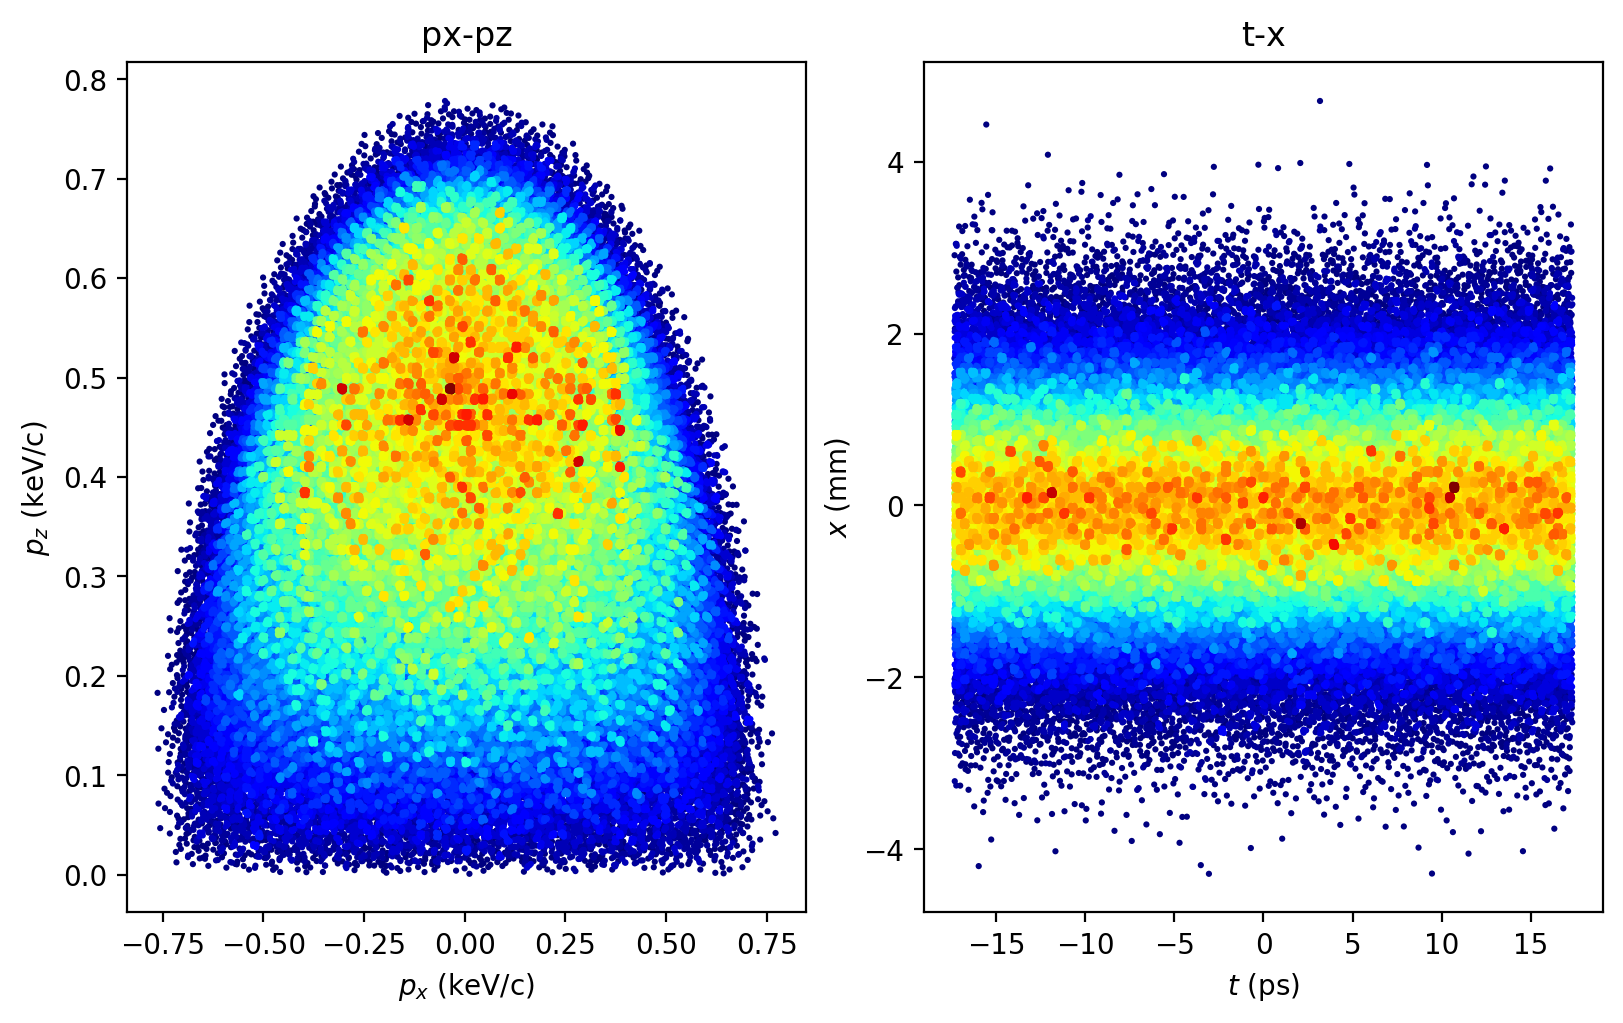

In [36]:
fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True, figsize=(8,5))

plot_dist2d(beam, 'px', units['px'], 'pz', units['pz'], ax=ax[0]);
ax[0].set_title('px-pz')

plot_dist2d(beam, 't', units['t'], 'x', units['x'], ax=ax[1]);
ax[1].set_title('t-x');

In [37]:
from distgen.physical_constants import PHYSICAL_CONSTANTS

c = PHYSICAL_CONSTANTS['speed of light in vacuum']
MC2 = PHYSICAL_CONSTANTS.species('electron')['mc2']

MTE = (c*beam['px'].std())**2 / MC2

print('estimated MTE:', MTE.to('meV'))

estimated MTE: 169.86710712122817 millielectron_volt


## 3. General Surface Emission defined by |P| or KE and $\theta_p$, $\phi_p$ distribution(s)
In addition to the two cathode emission models described above, the user may also specify a distribution for $|p|$ or the kinetic energy, as well as the momenta angle coordinates (azimuthal and polar momentum angles).  If no angular distribution parameters are set, then particles are emitted uniformly into the forward hemisphere.  In the example below, an initial KE distribution is created using a bi-exponential.

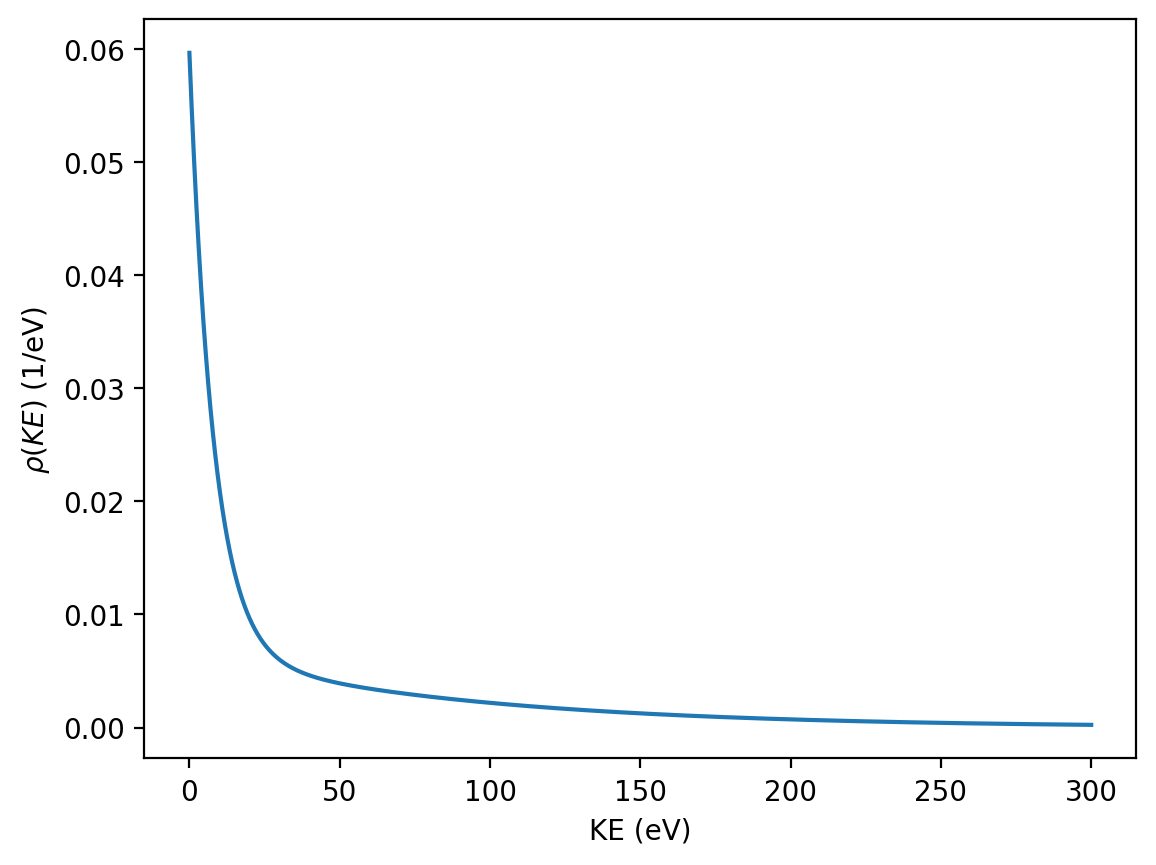

In [38]:
KE = np.linspace(0, 300, 10000)

E0=0
A1, m1 = 0.8, 8
A2, m2 = 0.1, 90

PKE = A1*np.exp(-np.abs(KE-E0)/m1) + A2*np.exp(-np.abs(KE-E0)/m2) 
PKE = PKE/np.trapz(PKE, KE)  # Numerically intergate to normalize

plt.plot(KE, PKE);
plt.xlabel('KE (eV)');
plt.ylabel('$\\rho(KE)$ (1/eV)');

In [39]:
input_yaml = """
n_particle: 100000
species: electron
start: 
  type: cathode
random:
  type: hammersley
total_charge:
  units: C
  value: 1.60217663e-17
"""

input = yaml.safe_load(input_yaml)
input['KE_dist'] = {'type': 'dist1d', 'KE':KE, 'PKE':PKE, 'units':'eV'}

gen = Generator(input)
P = gen.run()

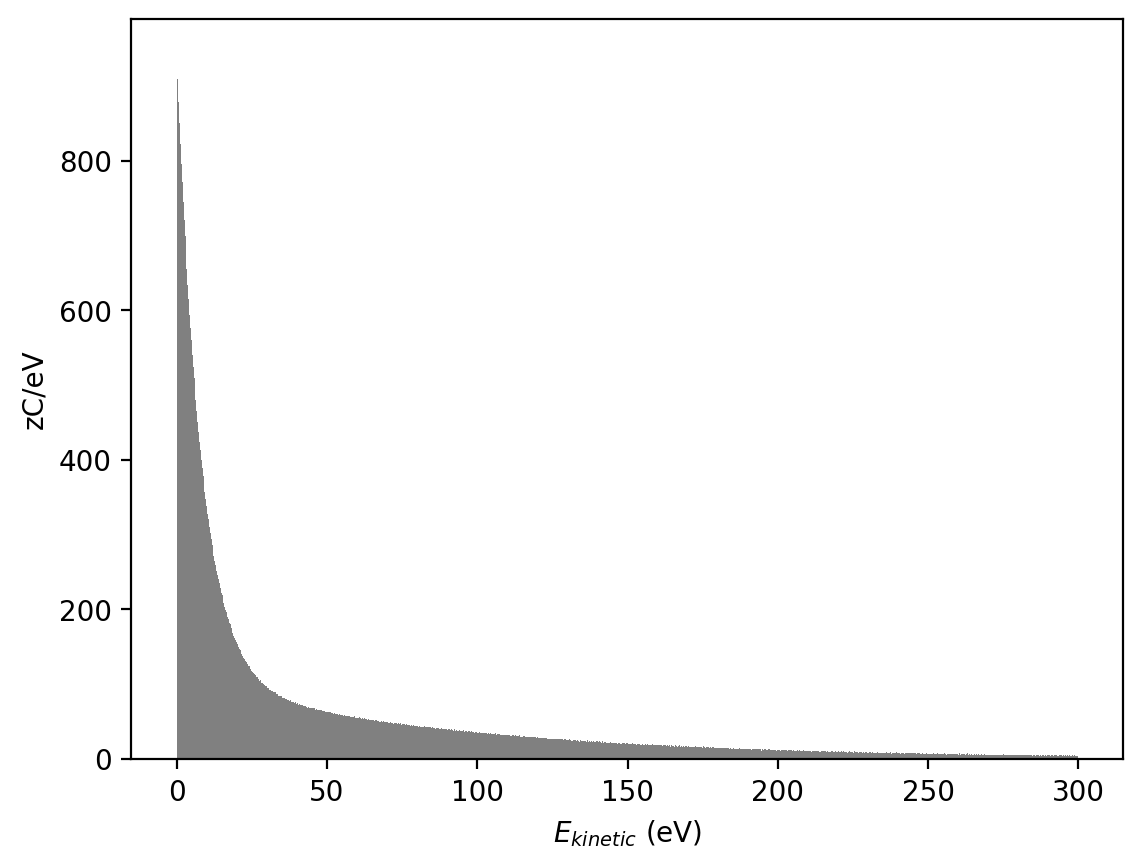

In [40]:
P.plot('kinetic_energy')

Text(0.5, 0, '$\\hat{p}_z$')

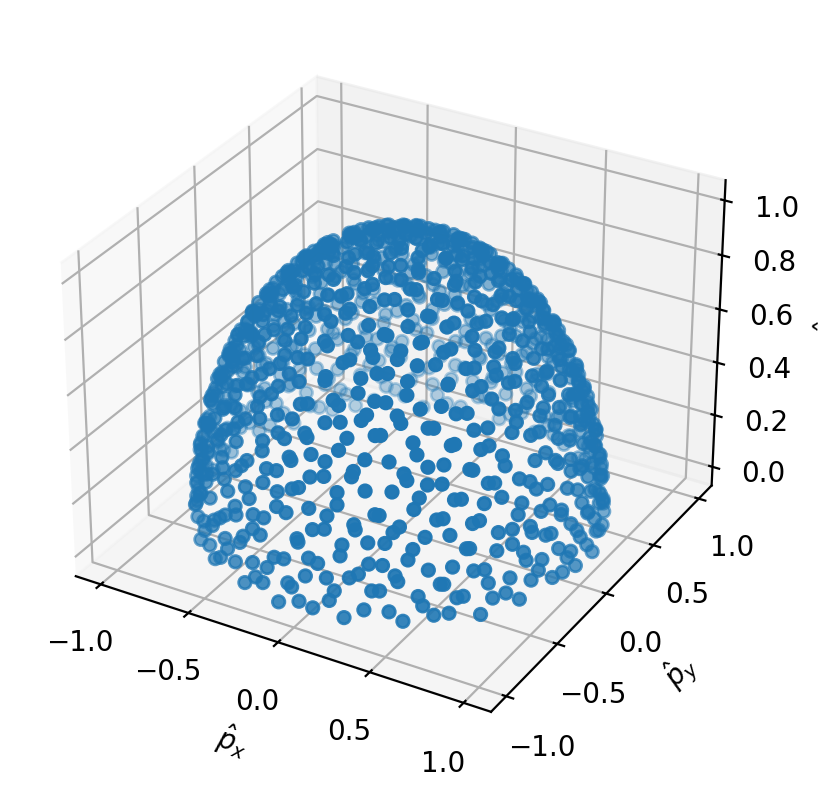

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = P['px']/P.p
y = P['py']/P.p
z = P['pz']/P.p

ax.scatter(x[::100], y[::100], z[::100], '.');
ax.set_xlabel(r'$\hat{p}_x$')
ax.set_ylabel(r'$\hat{p}_y$')
ax.set_zlabel(r'$\hat{p}_z$')

# Time Start

Distgen also allows the user to start a beam at an arbitrary time.  In this case, distgen will ignore any user distribution settings for the time coordinate of the beam particles.  The beam has some initial Gaussian momentum.  To make this more interesting, the beam is boosted to 1 GeV, the Twiss Parameters set, and a cosine like energy spread applied:

In [42]:
from distgen.physical_constants import unit_registry, PHYSICAL_CONSTANTS

pi, c = PHYSICAL_CONSTANTS.pi, PHYSICAL_CONSTANTS['speed of light in vacuum']

gen = Generator("data/gaussian.in.yaml", verbose=0) 

f = 1.3*unit_registry('GHz')
w = 2*pi*f/c

linac_params = {
    'type':'cosine z:pz',
    'amplitude':{'value':1,'units':'GeV/c'},
    'omega':{'value':w.magnitude, 'units':str(w.units)},
    'phase':{'value':-1, 'units':'deg'}
}

xbeta_params = {
    'type':'set_twiss x',
    'beta': {'value':12.5, 'units':'m'},
    'alpha':{'value':-1, 'units':''},
    'emittance':  {'value':2,'units':'nm'},
}
ybeta_params = {
    'type':'set_twiss y',
    'beta': {'value':12.5, 'units':'m'},
    'alpha':{'value':-1, 'units':''},
    'emittance':  {'value':2,'units':'nm'},
}

gen['transforms']={'t1':linac_params, 't2':xbeta_params, 't3':ybeta_params, 'order':['t1','t2','t3']}
  
beam = gen.beam()

print('YAML transforms input\n', yaml.dump(gen.input['transforms']))

print('\nFinal Horizontal Twiss params:')
print(f'beta: {beam.Beta("x"):G~P}, alpha: {beam.Alpha("x"):G~P}, eps: {beam.emitt("x","geometric").to("nm"):G~P}')
#print(f'beta: {beam.Beta("x"):G~P}, alpha: {beam.Alpha("x"):G~P}, eps: {beam.emitt("x","geometric").to("nm"):Gf~P}')

print('\nFinal Vertical Twiss params:')
print(f'beta: {beam.Beta("y"):G~P}, alpha: {beam.Alpha("y"):G~P}, eps: {beam.emitt("y","geometric").to("nm"):G~P}')

YAML transforms input
 order:
- t1
- t2
- t3
t1:
  amplitude:
    units: gigaelectron_volt / speed_of_light
    value: 1.0
  omega:
    units: gigahertz * radian * second / meter
    value: 2.724598528537186e-08
  phase:
    units: degree
    value: -1.0
  type: cosine z:pz
t2:
  alpha:
    units: dimensionless
    value: -1.0
  beta:
    units: meter
    value: 12.5
  emittance:
    units: nanometer
    value: 2.0
  type: set_twiss x
t3:
  alpha:
    units: dimensionless
    value: -1.0
  beta:
    units: meter
    value: 12.5
  emittance:
    units: nanometer
    value: 2.0
  type: set_twiss y


Final Horizontal Twiss params:
beta: 12500 mm, alpha: -1, eps: 2 nm

Final Vertical Twiss params:
beta: 12500 mm, alpha: -1, eps: 2 nm


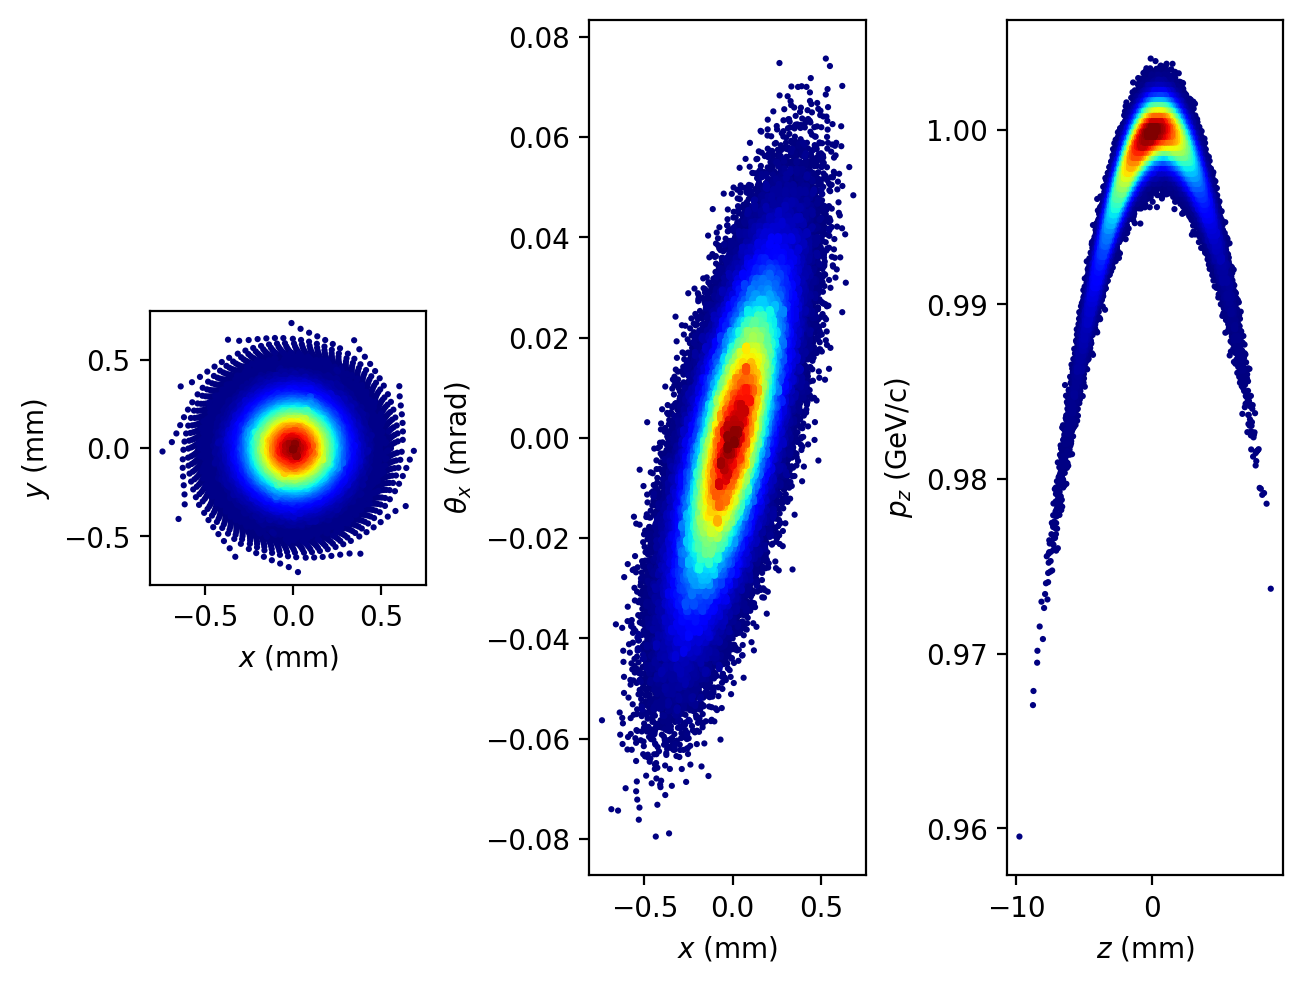

In [43]:
fig, ax = plt.subplots(1, 3, constrained_layout=True)
plot_dist2d(beam, 'x', units['x'], 'y', units['y'], axis='equal', ax=ax[0]);
plot_dist2d(beam, 'x', units['x'], 'thetax', units['thetax'], ax=ax[1]);
plot_dist2d(beam, 'z', units['z'],  'pz','GeV/c', ax=ax[2]);

# Combining Beams
Currently distgen supports combining beams in to ways.  The first makes use of the OpenPMD-beamphysics Particle Group's addition property.  This is achieved by making two separate beams:

In [44]:
filename = "data/gaussian.in.yaml"
gen = Generator(filename, verbose=0) 

gen['pz_dist:avg_pz'] = 1  # Set beam 1 at pz = 1 GeV
gen['z_dist:avg_z'] = -10  # Set beam 1 at z = -10 mmm

xbeta_params = {
    'type':'set_twiss x',
    'beta': {'value':12.5, 'units':'m'},
    'alpha':{'value':-1, 'units':''},
    'emittance':  {'value':2,'units':'nm'},
}

ybeta_params = {
    'type':'set_twiss y',
    'beta': {'value':12.5, 'units':'m'},
    'alpha':{'value':-1, 'units':''},
    'emittance':  {'value':2,'units':'nm'},
}

gen['transforms']={'t1':xbeta_params, 't2':ybeta_params, 'order':['t1','t2']}

pg1 = gen.run()

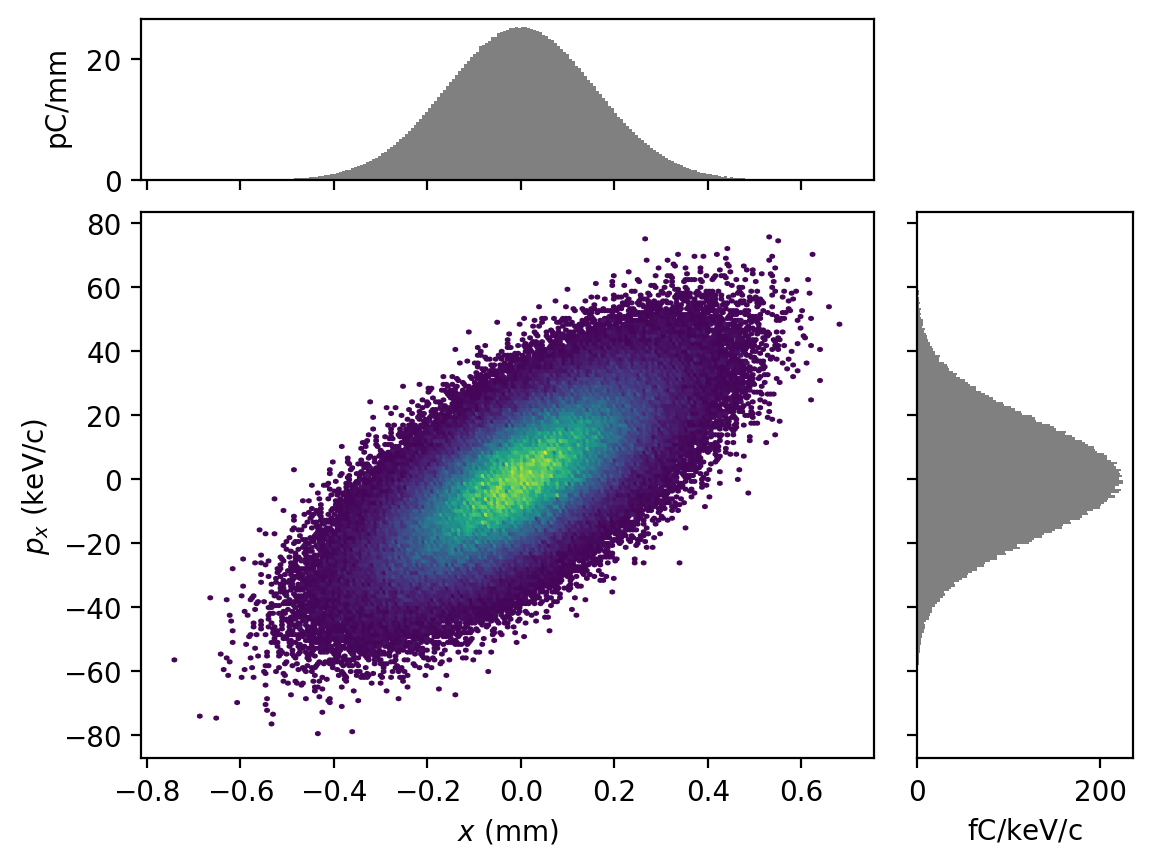

In [45]:
pg1.plot('x', 'px')

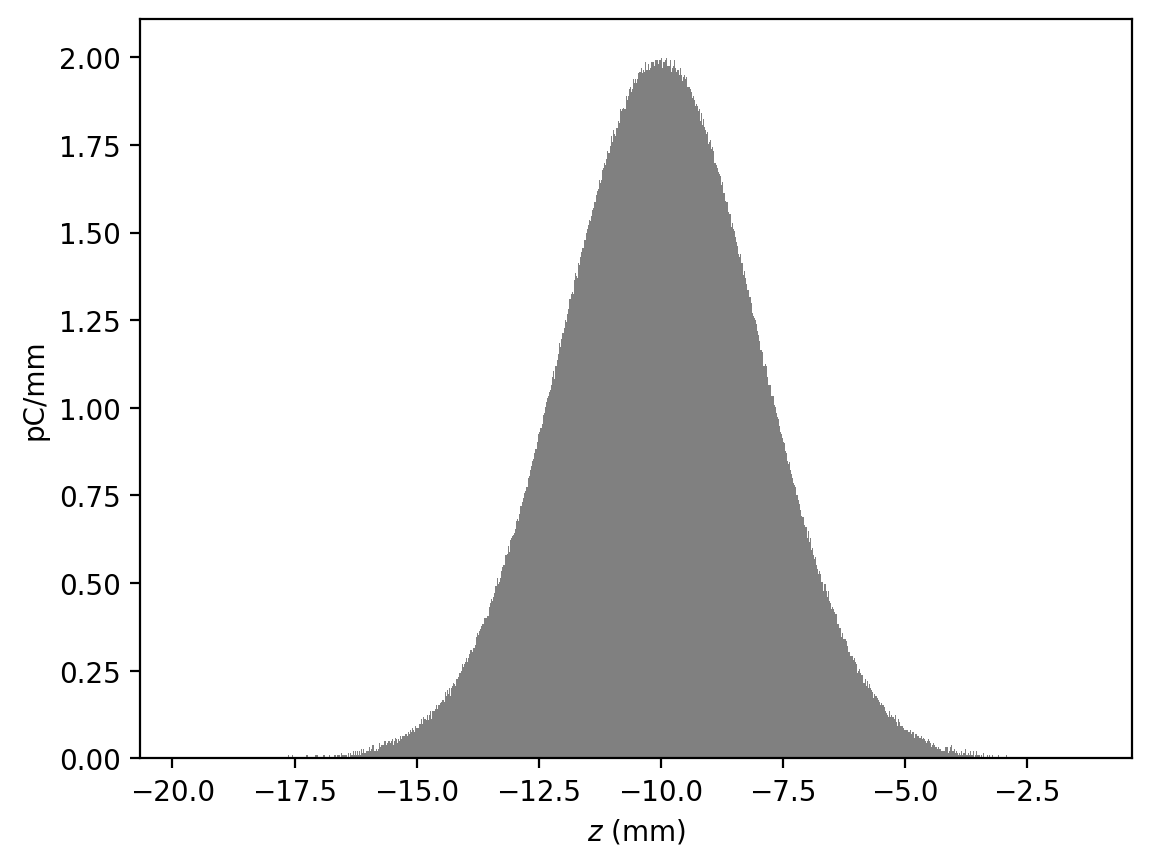

In [46]:
pg1.plot('z')

Next, make second beam.  Here shift the z position of the beam and change the $\alpha$ Twiss parameter's sign to create a different momenta distribution:

In [47]:
gen['z_dist:avg_z'] = 10   # Set beam 1 at z = +10 mmm

xbeta_params['alpha']['value'], ybeta_params['alpha']['value'] = +1, +1

gen['transforms']={'t1':xbeta_params, 't2':ybeta_params, 'order':['t1','t2']}

pg2 = gen.run()


The particle group objects support addition:

In [48]:
pg = pg1 + pg2

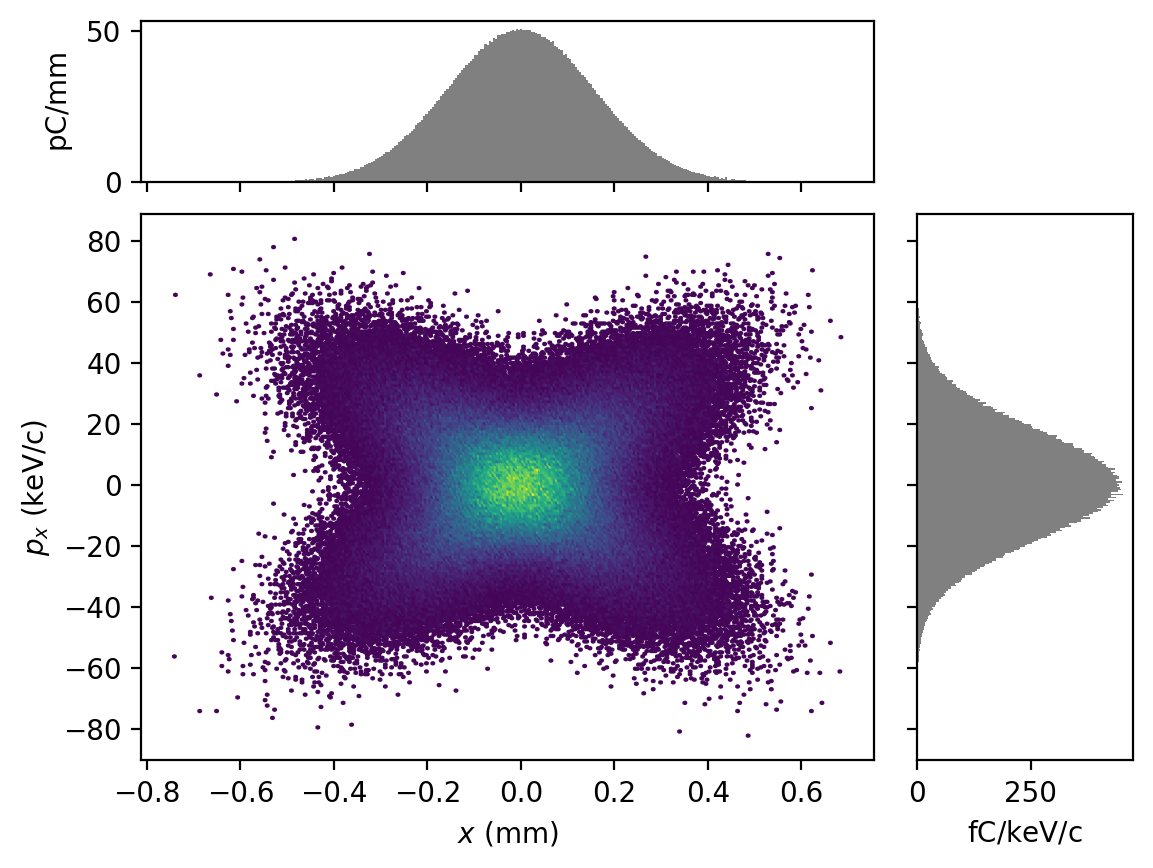

In [49]:
pg.plot('x','px')

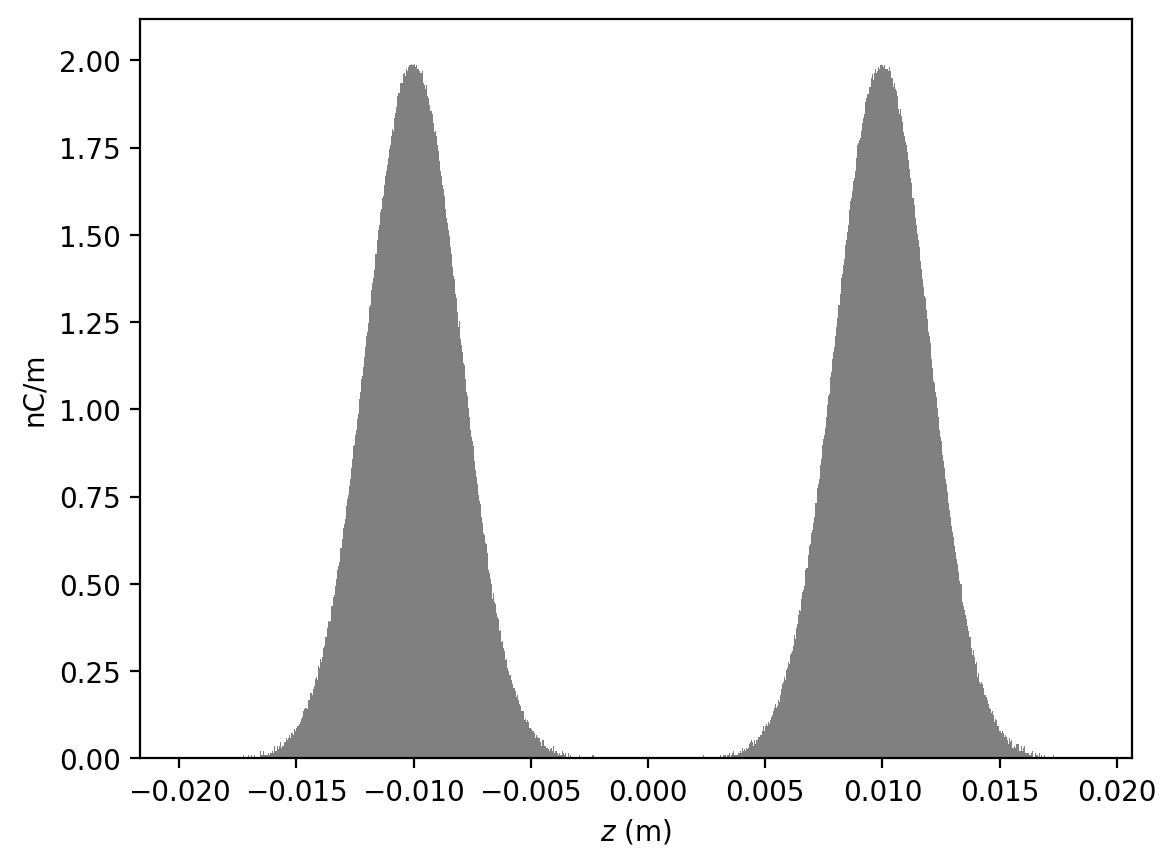

In [50]:
pg.plot('z')

It is also possible to superimpose built in distgen particle distributions.  Please see the `examples_dists.ipynb` for details on how to use this functionality.

# Archiving

All input and output can be saved and loaded to an hdf5 file using `.archive()` and `.load_archive` functions.

Input is archived as a flattended dict, with keys separated by `:`

Particlces are archived as openPMD-beamphysics, but only if they are created with the `run()` command.

In [51]:
gen = Generator("data/gaussian.in.yaml", verbose=0) 
gen.run()

<ParticleGroup with 200000 particles at 0x7f2090ca1970>

If no filename is given, a unique one will be written based on `.input`

In [52]:
afile = gen.archive()
afile

'distgen_5f231e3cd1846ec3f905eb9407815d00.h5'

Loading into a new object

In [53]:
G2 = Generator(verbose=True)
G2.load_archive(afile)

   Reading group ./ from archive file distgen_5f231e3cd1846ec3f905eb9407815d00.h5

open h5 handles can also be written to, using the same routine.

In [54]:
import h5py

with h5py.File('archive.h5', 'w') as h5:
    G2.archive(h5)

# Clean up
-------

In [55]:
os.remove('rad.gaussian.out.txt')
os.remove('gpt.out.txt')
os.remove('astra.out.txt')
os.remove('openPMD.out.h5')
#os.remove('beer.can.out.txt')
os.remove(afile)
os.remove('archive.h5')